In [28]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

In [30]:
%matplotlib inline

#from IPython.display import set_matplotlib_formats
#set_matplotlib_formats('pdf', 'svg')

import pandas as pd
import numpy as np
from IPython.display import HTML, display
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from itertools import product, combinations

## Sensitivity Plots

In [31]:
%autoreload

In [32]:
from flora_tools.radio_configuration import RadioConfiguration
from flora_tools.radio_math import RadioMath, SENSITIVITIES

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection

def is_pareto_optimal(item):
    competitors = df[(df.bitrate >= item.bitrate) & (df.bandwidth <= item.bandwidth) & (df.distance >= item.distance)]
    if len(competitors) > 1:
        return (0.0,0.0,0.0)
    else:
        return (1.0,0.0,0.0)
    
def get_color(item):
    if not np.isnan(item.sf):
        return RadioConfiguration(int(12 - item.sf)).color
    else:
        return (0.1,1.0,0.3)

df = pd.DataFrame(SENSITIVITIES)

df.loc[:,'distance'] = df.apply(RadioMath.get_theoretical_max_distance, axis=1)
df.loc[:,'bitrate'] = df.apply(RadioMath.get_bitrate, axis=1)

colors = df.apply(get_color, axis=1)
edgecolors = df.apply(is_pareto_optimal, axis=1)

fig = plt.figure(figsize=[12,12])
ax = fig.add_subplot(111, projection='3d')

for index, row in df.iterrows():
    ax.plot([row.bitrate, row.bitrate], [row.bandwidth, row.bandwidth], [0, row.distance], ':', c='#00000040')
    
ax.scatter(df.bitrate, df.bandwidth, df.distance, c=colors, edgecolors=edgecolors, s=100)

ax = plt.gca()
plt.xlabel("Bitrate [bps]")
plt.ylabel("Bandwidth [Hz]")
ax.set_zlabel("Max. Distance @ 22 dBm [m]")

plt.show()

df.style
    
    

ValueError: operands could not be broadcast together with remapped shapes [original->remapped]: (33,4) and requested shape (7,4)

<Figure size 864x864 with 1 Axes>

,bandwidth,bitrate,fda,modem,sensitivity,sf,distance
0,4000,600,800,RadioModem.FSK,-125,nan,6642.48
1,20000,1200,5000,RadioModem.FSK,-123,nan,5697.22
2,20000,4800,5000,RadioModem.FSK,-118,nan,3881.47
3,83000,38400,40000,RadioModem.FSK,-109,nan,1945.34
4,50000,38400,20000,RadioModem.FSK,-109,nan,1945.34
5,250000,250000,62500,RadioModem.FSK,-96,nan,717.238
6,500000,250000,125000,RadioModem.FSK,-104,nan,1325.35
7,10400,nan,nan,RadioModem.LORA,-148,12,38814.7
8,10400,nan,nan,RadioModem.LORA,-135,7,14310.8
9,125000,nan,nan,RadioModem.LORA,-137,12,16685.1


# Energy Plots

In [6]:
%autoreload

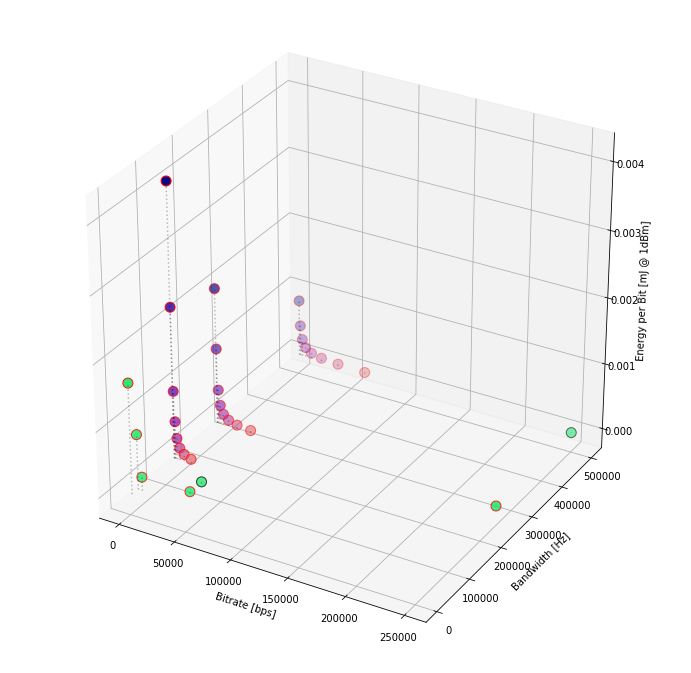

,bandwidth,bitrate,fda,modem,sensitivity,sf,energy
0,4000,600,800,FSK,-125,nan,0.00167402
1,20000,1200,5000,FSK,-123,nan,0.00083701
2,20000,4800,5000,FSK,-118,nan,0.000209252
3,83000,38400,40000,FSK,-109,nan,2.61566e-05
4,50000,38400,20000,FSK,-109,nan,2.61566e-05
5,250000,250000,62500,FSK,-96,nan,4.01765e-06
6,500000,250000,125000,FSK,-104,nan,4.01765e-06
7,125000,244.141,nan,LoRa,-137,12,0.00411056
8,125000,439.453,nan,LoRa,-133,11,0.00228618
9,125000,976.562,nan,LoRa,-132,10,0.00103015


In [7]:
from flora_tools.radio_configuration import RadioConfiguration
from flora_tools.radio_math import RadioMath, SENSITIVITIES

from mpl_toolkits.mplot3d import Axes3D

def is_pareto_optimal(item):
    competitors = df[(df.bitrate >= item.bitrate) & (df.bandwidth <= item.bandwidth) & (df.energy >= item.energy)]
    if len(competitors) > 1:
        return (0.0,0.0,0.0)
    else:
        return (1.0,0.0,0.0)
    
def get_color(item):
    if not np.isnan(item.sf):
        return RadioConfiguration(12 - item.sf).color
    else:
        return (0.1,0.9,0.4)

df = pd.DataFrame(SENSITIVITIES)

df.loc[:,'energy'] = df.apply(RadioMath.get_energy_per_bit, axis=1)
df.loc[:,'bitrate'] = df.apply(RadioMath.get_bitrate, axis=1)

colors = df.apply(get_color, axis=1)
edgecolors = df.apply(is_pareto_optimal, axis=1)

fig = plt.figure(figsize=[12,12])
ax = fig.add_subplot(111, projection='3d')

for index, row in df.iterrows():
    ax.plot([row.bitrate, row.bitrate], [row.bandwidth, row.bandwidth], [0, row.energy], ':', c='#00000040')
    
ax.scatter(df.bitrate, df.bandwidth, df.energy, c=colors, edgecolors=edgecolors, s=100)

ax = plt.gca()
plt.xlabel("Bitrate [bps]")
plt.ylabel("Bandwidth [Hz]")
ax.set_zlabel("Energy per Bit [mJ @ 1dBm]")

plt.show()

df.style
    
    